In [6]:
# Imports
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, ResNet50, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import pickle

In [2]:
# Use Mixed Precision (save VRAM)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
print("mixed precision enabled.")

mixed precision enabled.


In [3]:
# Load Preprocessed Data --- balanced checked
DATA_PATH = "/kaggle/input/preprocessed-mammo-splits"  
train = np.load(os.path.join(DATA_PATH, "train_data.npz"))
val = np.load(os.path.join(DATA_PATH, "val_data.npz"))
test = np.load(os.path.join(DATA_PATH, "test_data.npz"))

X_train, y_train = train["X"], train["y"]
X_val, y_val = val["X"], val["y"]
X_test, y_test = test["X"], test["y"]


In [4]:
# Normalize
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

In [7]:
# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.1308917197452228, 1: 0.8962645128722867}


In [8]:
def convert_to_rgb(image, label):
    image_rgb = tf.image.grayscale_to_rgb(image)  
    image_rgb = tf.squeeze(image_rgb) 
    return image_rgb, label

In [11]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Expand dims because TF expects (H, W, 1) from (H, W)
X_train = X_train[..., np.newaxis].astype("float32")
X_val = X_val[..., np.newaxis].astype("float32")
X_test = X_test[..., np.newaxis].astype("float32")

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle, batch, convert to RGB, prefetch
train_ds = (
    train_ds.shuffle(1024)
    .map(convert_to_rgb, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds.map(convert_to_rgb, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds.map(convert_to_rgb, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


In [12]:
def build_model(base_model_fn, name="model"):
    base_model = base_model_fn(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False  

    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)  
    x = GlobalAveragePooling2D()(x) 
    x = Dropout(0.3)(x)  
    x = Dense(128, activation='relu')(x)  
    outputs = Dense(1, activation='sigmoid', dtype='float32')(x)  

    model = Model(inputs, outputs, name=name)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]) 
    return model

In [13]:
# Prepare Callbacks
os.makedirs("/kaggle/working/models", exist_ok=True)
callbacks = lambda name: [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(f"/kaggle/working/models/{name}.keras", save_best_only=True)
]

In [14]:
# Train and Save Models
models = {
    "EfficientNetB0": EfficientNetB0,
    "ResNet50": ResNet50,
    "DenseNet121": DenseNet121
}

history_dict = {}

for name, fn in models.items():
    print(f"\nTraining {name}...")
    
    # Build model
    model = build_model(fn, name=name)
    
    # Train model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=callbacks(name),
        verbose=2
    )

    # Save model
    model.save(f"{name}_trained_model.h5")
    print(f"Saved model: {name}_trained_model.h5")

    # Save training history
    history_dict[name] = history.history
    with open(f"{name}_history.pkl", "wb") as f:
        pickle.dump(history.history, f)
    print(f"Saved training history: {name}_history.pkl")

print("\n Training completed and all models & histories saved.")



Training EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10


I0000 00:00:1745304846.284217      90 service.cc:148] XLA service 0x7b94e0002e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745304846.285353      90 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745304848.361292      90 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745304858.938882      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


555/555 - 73s - 132ms/step - accuracy: 0.4949 - auc: 0.5035 - loss: 0.6936 - val_accuracy: 0.5578 - val_auc: 0.5000 - val_loss: 0.6872
Epoch 2/10
555/555 - 14s - 26ms/step - accuracy: 0.5098 - auc: 0.5071 - loss: 0.6933 - val_accuracy: 0.5578 - val_auc: 0.5000 - val_loss: 0.6895
Epoch 3/10
555/555 - 14s - 26ms/step - accuracy: 0.4956 - auc: 0.5013 - loss: 0.6935 - val_accuracy: 0.5578 - val_auc: 0.5000 - val_loss: 0.6878
Epoch 4/10
555/555 - 14s - 25ms/step - accuracy: 0.4975 - auc: 0.5041 - loss: 0.6934 - val_accuracy: 0.5578 - val_auc: 0.5027 - val_loss: 0.6883
Saved model: EfficientNetB0_trained_model.h5
Saved training history: EfficientNetB0_history.pkl

Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
555/555 - 62s - 111ms/step - accuracy: 0.5028 - auc: 0.5020 - loss: 0.7052 - val_accuracy: 0.5578 - val_auc: 0.4956 - val_loss: 0.6890
Epoch 2/10
555/555 - 27s - 49ms/step - accuracy: 0.5005 - auc: 0.5026 - loss: 0.6999 - val_accuracy: 0.5578 - val_a

Validation class distribution: Counter({1: 1748, 0: 1386})

Evaluating EfficientNetB0...
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step
EfficientNetB0 - Prediction stats: min=0.5645, max=0.5645, mean=0.5645


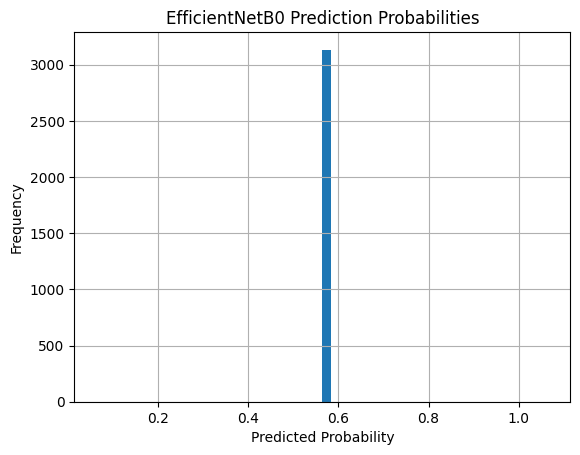


Best threshold (Youden’s J): 1.5645

Metrics for EfficientNetB0:
Confusion Matrix:
[[1386    0]
 [1748    0]]
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC-AUC Score: 0.5000

Evaluating ResNet50...
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step
ResNet50 - Prediction stats: min=0.5474, max=0.5480, mean=0.5477


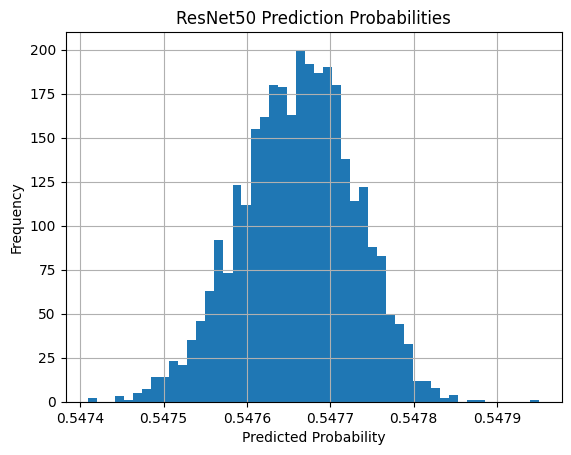


Best threshold (Youden’s J): 0.5476

Metrics for ResNet50:
Confusion Matrix:
[[ 600  786]
 [ 650 1098]]
Precision: 0.5828
Recall: 0.6281
F1 Score: 0.6046
ROC-AUC Score: 0.5312

Evaluating DenseNet121...
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step
DenseNet121 - Prediction stats: min=0.5582, max=0.5697, mean=0.5640


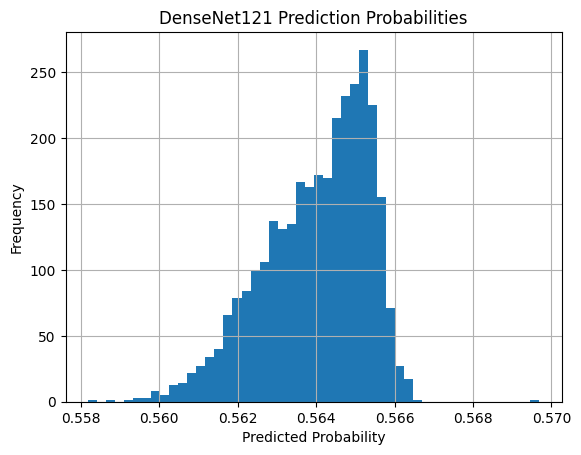


Best threshold (Youden’s J): 0.5643

Metrics for DenseNet121:
Confusion Matrix:
[[ 893  493]
 [ 735 1013]]
Precision: 0.6726
Recall: 0.5795
F1 Score: 0.6226
ROC-AUC Score: 0.6382

✅ Metrics evaluation completed for all models.


In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve
)
import collections
import os

# Load class labels from val_ds
y_true = np.concatenate([label.numpy() for _, label in val_ds])
print("Validation class distribution:", collections.Counter(y_true))

# Define models to evaluate
models = {
    "EfficientNetB0": "models/EfficientNetB0.keras",
    "ResNet50": "models/ResNet50.keras",
    "DenseNet121": "models/DenseNet121.keras"
}

def log_metrics(y_true, y_probs, model_name):
    # Plot histogram of predicted probabilities
    plt.hist(y_probs, bins=50)
    plt.title(f"{model_name} Prediction Probabilities")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Compute optimal threshold using Youden's J statistic
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    j_scores = tpr - fpr
    j_best_idx = np.argmax(j_scores)
    best_thresh = thresholds[j_best_idx]
    print(f"\nBest threshold (Youden’s J): {best_thresh:.4f}")

    # Convert probabilities to predicted classes
    y_pred = (y_probs > best_thresh).astype("int32")

    # Compute metrics
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)

    # Log metrics
    print(f"\nMetrics for {model_name}:")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC Score: {auc:.4f}")

# Evaluate each model
for model_name, model_path in models.items():
    print(f"\nEvaluating {model_name}...")

    # Load the model
    model = tf.keras.models.load_model(model_path)

    # Predict probabilities on val_ds
    y_probs = model.predict(val_ds, verbose=1).flatten()
    print(f"{model_name} - Prediction stats: min={y_probs.min():.4f}, max={y_probs.max():.4f}, mean={y_probs.mean():.4f}")

    # Log all metrics
    log_metrics(y_true, y_probs, model_name)

print("\n✅ Metrics evaluation completed for all models.")


In [17]:
for _, label in val_ds.take(1):
    print("Sample label shape:", label.shape)
    print("Label content:", label)


Sample label shape: (32,)
Label content: tf.Tensor([1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1], shape=(32,), dtype=int64)
